# #132 Arbitrary section calculation
<i>Generate Arbitrary section definitions from spreadsheet inputs.</i>
***

In [ ]:
# xlsx file containing the definitions
file_name = "Datafiles/Box Section Adv Definitions.xlsx"

In [ ]:
import numpy as np
import pandas as pd
import math
import sys; sys.path.append('../') # Reference modules in parent directory
from LPI import *
lusas = get_lusas_modeller()

if not lusas.existsDatabase():
    raise Exception("A model file must be open in which to create the RC Section Definitions")

import Helpers as Helpers
Helpers.initialise(lusas)

db = lusas.getDatabase()
model_units = db.getModelUnits()
model_length_factor = model_units.getLengthFactor()
print(model_length_factor)

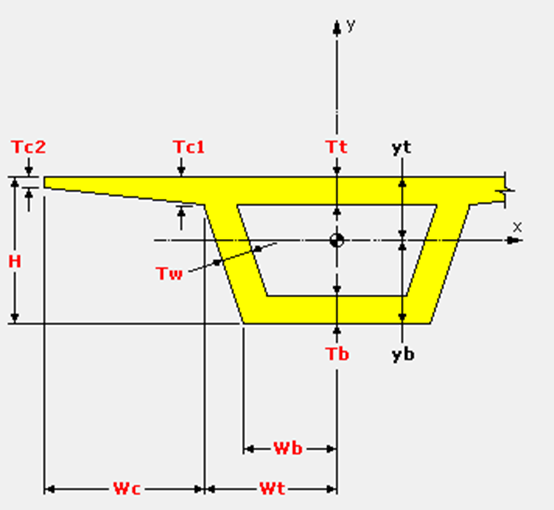

In [ ]:
# Create the reinforced simple box section definition
df_simple_box = pd.read_excel(file_name, sheet_name="Simple")

for i, row in df_simple_box.iterrows():

    # Useful coords
    x1 = row.Wb; x2 = row.Wt;          x3 = (row.Wt + row.Wc)
    y1 = 0;      y2 = row.H - row.Tc1; y3 = row.H - row.Tc2; y4 = row.H

    tw = row.Tw
    theta_w = math.atan(y3 / (x2-x1))

    isVoided = row.Void == "Yes"

    # New model for the arbitray section
    try:
        aspc = lusas.newASPCDatabase()
        aspc.setModelUnits(row.Units)
        lusas.getProject().setCurrentDatabase(aspc)

        xs = [x1, x2, x3, x3, -x3, -x3, -x2, -x1]
        ys = [y1, y2, y3, y4, y4, y3, y2, y1]
        zs = [0] * len(xs)

        outline = Helpers.create_surface_by_coordinates(xs, ys, zs)

        if(isVoided):
            # Adjust for the inner void
            sin_t = 1 / math.sin(theta_w)
            x1 = x1 - tw * sin_t + row.Tb / math.tan(theta_w)
            x2 = x2 - tw * sin_t
            y1 = y1 + row.Tb

            xs = [x1, x2, -x2, -x1]
            ys = [y1, y2, y2, y1]
            zs = [0] * len(xs)

            void = Helpers.create_surface_by_coordinates(xs, ys, zs)

            # remove the void
            objs = lusas.newObjectSet().add(outline).add(void)
            objs.booleanSubtraction()

        attr = db.createArbitrarySection(row["Name"]).fromDatabase(aspc)
    except:
        print("Failed")
    finally:
        aspc.close()
        print("ok")

# Restore the current database
lusas.getProject().setCurrentDatabase(db)
